In [20]:
%pylab inline

import pandas as pd
import seaborn as sns
sns.set()
import pickle
from sklearn.neighbors import KNeighborsClassifier , RadiusNeighborsClassifier
from sklearn.model_selection import train_test_split , cross_val_score, StratifiedShuffleSplit, cross_val_predict
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn import metrics
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


In [3]:
with open('atxac_de.pickle', 'rb') as read_aacde:
    atxac_df = pickle.load(read_aacde)

In [43]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=88 )
for train_index, test_index in split.split(atxac_df, atxac_df['Updated_Outcome_Type']):
    strat_train_set = atxac_df.loc[train_index]
    strat_test_set = atxac_df.loc[test_index]

In [44]:
X_train = strat_train_set.drop(columns=['Outcome_Type','Updated_Outcome_Type'])
y_train = strat_train_set['Updated_Outcome_Type']
X_test = strat_test_set.drop(columns=['Outcome_Type','Updated_Outcome_Type'])
y_test = strat_test_set['Updated_Outcome_Type']

In [4]:
X = atxac_df.drop(columns=['Outcome_Type','Updated_Outcome_Type'])
y = atxac_df['Updated_Outcome_Type']

In [24]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=.2, random_state=88,stratify=y)

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=24,stratify=y_train_val)

In [38]:
y_pred

array(['Transfer', 'Adoption', 'Transfer', ..., 'Transfer', 'Transfer',
       'Adoption'], dtype=object)

In [48]:
X_train.shape

(30768, 25)

In [49]:
X_val.shape

(10257, 25)

In [ ]:
"""['Intake_Type', 'Intake_Condition', 'Sex_Upon_Outcome', 'OutcomeBreed','OutcomeColor','TimeSinceIntake','AgeYrs','No_Known_Owner']"""
#'Outcome_Type'
#'Outcome_Subtype'
# 'Outcome_Age','Outcome_Animal_Type'

In [ ]:
#Stand. - 'AgeYrs' , 'TimeSinceIntake'
#
#OHE - 'Sex_Upon_Outcome', 'OutcomeBreed' , 'OutcomeColor','Intake_Type','Intake_Condition'

In [9]:
atxac_df.head()

,Animal_ID,Name,IntakeDateTime,IntakeMonthYear,Found_Location,Intake_Type,Intake_Condition,Animal_Type,Sex_Upon_Intake,Age_Upon_Intake,...,Outcome_Subtype,Outcome_Animal_Type,Sex_Upon_Outcome,Outcome_Age,OutcomeBreed,OutcomeColor,No_Known_Owner,TimeSinceIntake,Updated_Outcome_Type,AgeYrs
0,A696409,*Hans,2015-02-04 13:23:00,02/04/2015 01:23:00 PM,2101 E 12Th St in Austin (TX),Stray,Normal,Cat,Intact Male,2 months,...,None,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black,1.0,5 days 05:23:00,Adoption,0.166667
1,A782089,Unknown,2018-10-10 14:27:00,10/10/2018 02:27:00 PM,5918 Alsace Trail in Austin (TX),Stray,Injured,Cat,Intact Female,2 years,...,Suffering,Cat,Intact Female,2 years,Domestic Shorthair Mix,Tan/Black,0.0,0 days 06:33:00,Other,2.000000
2,A739966,*Skippyjohn,2016-12-09 16:08:00,12/09/2016 04:08:00 PM,Pleasant Valley And Nuckols Crossing in Austin...,Stray,Normal,Cat,Intact Male,4 weeks,...,Foster,Cat,Neutered Male,3 months,Siamese Mix,Seal Point,1.0,62 days 15:26:00,Adoption,0.250000
3,A739966,*Skippyjohn,2017-02-08 13:08:00,02/08/2017 01:08:00 PM,Pflugerville (TX),Owner Surrender,Normal,Cat,Neutered Male,2 months,...,Foster,Cat,Neutered Male,3 months,Siamese Mix,Seal Point,1.0,1 days 18:26:00,Adoption,0.250000
4,A738706,Unknown,2016-11-19 15:28:00,11/19/2016 03:28:00 PM,5500 Ponciana in Austin (TX),Stray,Normal,Cat,Intact Female,2 years,...,SCRP,Cat,Intact Female,2 years,Domestic Shorthair Mix,Orange Tabby,0.0,0 days 17:32:00,Transfer,2.000000


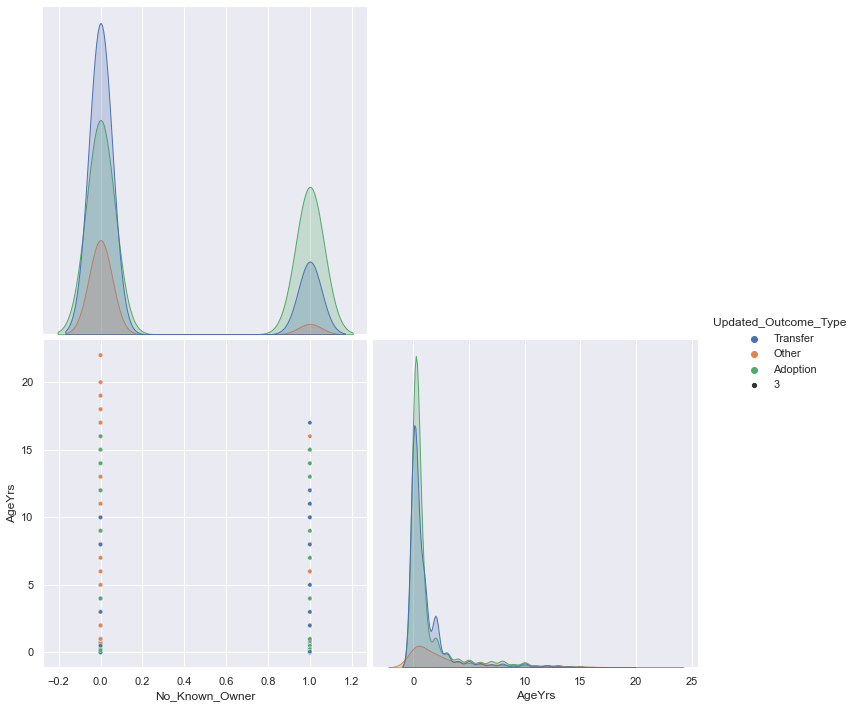

In [23]:
sns.pairplot(pd.concat([X_train_val,y_train_val],axis=1), corner=True, height=5, plot_kws={'size': 3}, hue='Updated_Outcome_Type');

<AxesSubplot:xlabel='Sex_Upon_Outcome', ylabel='count'>

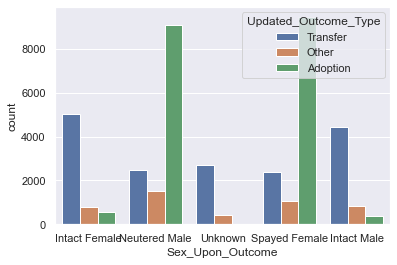

In [17]:
sns.countplot(x = X_train_val['Sex_Upon_Outcome'], hue=y_train_val, data=pd.concat([X_train_val,y_train_val],axis=1))

<AxesSubplot:xlabel='Intake_Type', ylabel='count'>

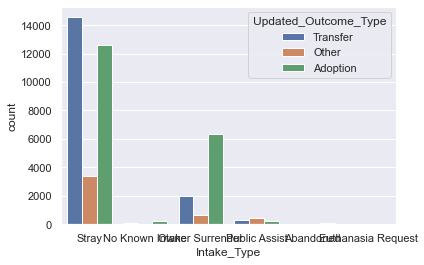

In [21]:
sns.countplot(x = X_train_val['Intake_Type'], hue=y_train_val, data=pd.concat([X_train_val,y_train_val],axis=1))

<AxesSubplot:xlabel='Intake_Condition', ylabel='count'>

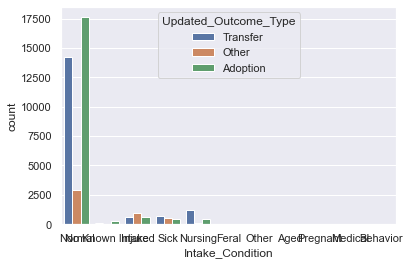

In [22]:
sns.countplot(x = X_train_val['Intake_Condition'], hue=y_train_val, data=pd.concat([X_train_val,y_train_val],axis=1))

In [23]:
atxac_df['Intake_Type'].value_counts(dropna=False)

Stray                 38114
Owner Surrender       11354
Public Assist          1223
NaN                     426
Abandoned                98
Euthanasia Request       67
Name: Intake_Type, dtype: int64

In [6]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train[['Sex_Upon_Outcome','Intake_Type','Intake_Condition']])
top3 = ohe.transform(X_train[['Sex_Upon_Outcome','Intake_Type','Intake_Condition']]).toarray()

NameError: name 'X_train' is not defined

In [31]:
top3.shape

(30768, 22)

In [32]:
knn = KNeighborsClassifier()
knn.fit(top3,y_train)

KNeighborsClassifier()

In [34]:
top3_val = ohe.transform(X_val[['Sex_Upon_Outcome','Intake_Type','Intake_Condition']]).toarray()

In [35]:
top3_val.shape

(10257, 22)

In [36]:
y_pred = knn.predict(top3_val)
metrics.accuracy_score(y_val,y_pred)

0.7418348444964414

In [37]:
from sklearn.metrics import confusion_matrix
print("kNN confusion matrix: \n\n", confusion_matrix(y_val, y_pred,labels=['Adoption','Transfer','Other']))

kNN confusion matrix: 

 [[4459  233  181]
 [1200 2825  216]
 [ 470  348  325]]


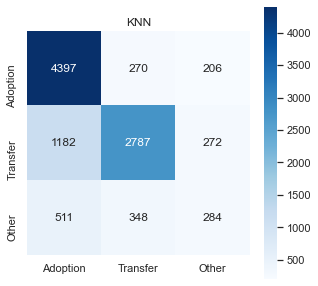

In [55]:
knn_confusion = confusion_matrix(y_val, y_pred,labels=['Adoption','Transfer','Other'])
figsize(5,5)
sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt="d", xticklabels=['Adoption','Transfer','Other'],
           yticklabels=['Adoption','Transfer','Other'])
title('KNN');

In [38]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train[['Sex_Upon_Outcome','Intake_Type','Intake_Condition','OutcomeBreed' , 'OutcomeColor']])
all5 = ohe.transform(X_train[['Sex_Upon_Outcome','Intake_Type','Intake_Condition','OutcomeBreed' , 'OutcomeColor']]).toarray()

In [40]:
knn = KNeighborsClassifier()
knn.fit(all5,y_train)

KNeighborsClassifier()

In [39]:
all5_val = ohe.transform(X_val[['Sex_Upon_Outcome','Intake_Type','Intake_Condition','OutcomeBreed' , 'OutcomeColor']]).toarray()

In [42]:
y_pred = knn.predict(all5_val)
metrics.accuracy_score(y_val,y_pred)

0.7280881349322414

In [43]:
print("kNN confusion matrix: \n\n", metrics.confusion_matrix(y_val, y_pred,labels=['Adoption','Transfer','Other']))

kNN confusion matrix: 

 [[4397  270  206]
 [1182 2787  272]
 [ 511  348  284]]


In [14]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train_val[['Sex_Upon_Outcome','Intake_Type','Intake_Condition']])
top3 = ohe.transform(X_train_val[['Sex_Upon_Outcome','Intake_Type','Intake_Condition']]).toarray()

In [16]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(top3,y_train_val)

In [17]:
# Yay, balanced classes!
Counter(y_resampled)

Counter({'Transfer': 19491, 'Other': 19491, 'Adoption': 19491})

In [18]:
knn = KNeighborsClassifier()
cross_val_score(knn,X_resampled,y_resampled)

array([0.57366396, 0.58606242, 0.56733647, 0.64220968, 0.63476997])

In [21]:
y_pred = cross_val_predict(knn, X_resampled, y_resampled)

In [23]:
from sklearn.metrics import confusion_matrix
print("kNN_ros confusion matrix: \n\n", confusion_matrix(y_train_val, y_pred,labels=['Adoption','Transfer','Other']))

ValueError: Found input variables with inconsistent numbers of samples: [41025, 58473]

In [27]:
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_train[['Sex_Upon_Outcome','Intake_Type','Intake_Condition']])
top3 = ohe.transform(X_train[['Sex_Upon_Outcome','Intake_Type','Intake_Condition']]).toarray()
top3_val = ohe.transform(X_val[['Sex_Upon_Outcome','Intake_Type','Intake_Condition']]).toarray()

In [28]:
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_sample(top3,y_train)

In [31]:
Counter(y_resampled)

Counter({'Transfer': 14618, 'Other': 14618, 'Adoption': 14618})

In [29]:
knn = KNeighborsClassifier()
knn.fit(X_resampled,y_resampled)

KNeighborsClassifier()

In [30]:
y_pred = knn.predict(top3_val)
metrics.accuracy_score(y_val,y_pred)
from sklearn.metrics import confusion_matrix
print("kNN confusion matrix: \n\n", confusion_matrix(y_val, y_pred,labels=['Adoption','Transfer','Other']))

kNN confusion matrix: 

 [[3185 1584  104]
 [ 810 3208  223]
 [ 342  464  337]]


In [33]:
X_adasyn, y_adasyn = ADASYN(sampling_strategy='minority').fit_sample(top3,y_train)

In [35]:
Counter(y_adasyn)

Counter({'Transfer': 12720, 'Other': 15386, 'Adoption': 14618})

In [36]:
knn = KNeighborsClassifier()
knn.fit(X_adasyn,y_adasyn)

KNeighborsClassifier()

In [37]:
y_pred = knn.predict(top3_val)
metrics.accuracy_score(y_val,y_pred)
from sklearn.metrics import confusion_matrix
print("kNN confusion matrix: \n\n", confusion_matrix(y_val, y_pred,labels=['Adoption','Transfer','Other']))

kNN confusion matrix: 

 [[3696  828  349]
 [ 987 2001 1253]
 [ 373  292  478]]


In [40]:
X_adasyn, y_adasyn = ADASYN(sampling_strategy='minority').fit_sample(all5,y_train)
Counter(y_adasyn)

Counter({'Transfer': 12720, 'Other': 14707, 'Adoption': 14618})

In [41]:
knn = KNeighborsClassifier()
knn.fit(X_adasyn,y_adasyn)
y_pred = knn.predict(all5_val)
print("RF confusion matrix: \n\n", metrics.confusion_matrix(y_val, y_pred,labels=['Adoption','Transfer','Other']))

RF confusion matrix: 

 [[3971  405  497]
 [1078 2498  665]
 [ 430  255  458]]
